## Scenario 1

Non-age structured model with b~=0

* training data: (samples of) WF model with $b\in[-0.001,0.0006]$
* observed data: samples (n=50,100,500,1000,2000) from WF model with specific $b_i$ values 
* outcome: 1-P(neutral)

We plot the $b_i$ values on the x-axis and the 1-P(neutral ) on the y-axis and compare this to the rejection probability obtained from the Ewens-Watterson test.

In [1]:
import os
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

In [2]:
%run ../src/dataset.py
%run ../src/augmentation.py
%run ../src/simulation.py
%run ../src/utils.py

In [71]:
def load_data(fp):
    data = {}
    for n in (100, 500, 1000, 2000):
        transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
        data[n] = PresimulatedDataset.load(fp, transform=transform)
    return data

In [72]:
SCENARIO1_TRAINDATA = load_data("../data/scenario-1-trainset-new.npz")

In [73]:
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


with open("clf_params.json") as f:
    PARAMS = json.load(f)

models = {}

for n in (100, 500, 1000, 2000):
    data = SCENARIO1_TRAINDATA[n]
    X, theta = data.dataset, data.theta
    X_train, X_dev, theta_train, theta_dev = train_test_split(
        X, theta, test_size=0.1, shuffle=True)

    y_train = (theta_train[:, 0].numpy() != 0).astype(int)
    y_dev = (theta_dev[:, 0].numpy() != 0).astype(int)
    
    clf = ExtraTreesClassifier(n_jobs=10, **PARAMS[f"1-{n}"])
    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_dev)[:, 1]
    score = roc_auc_score(y_dev, probs)
    
    models[n] = {
        "clf": clf,
        "dev score": score
    }

In [74]:
models

{100: {'clf': ExtraTreesClassifier(bootstrap=True, max_depth=10, max_features='sqrt',
                       min_samples_split=9, n_estimators=700, n_jobs=10),
  'dev score': 0.8747014892536131},
 500: {'clf': ExtraTreesClassifier(bootstrap=True, max_depth=20, max_features='sqrt',
                       min_samples_split=18, n_estimators=1500, n_jobs=10),
  'dev score': 0.9232517930327868},
 1000: {'clf': ExtraTreesClassifier(bootstrap=True, max_depth=10, max_features='sqrt',
                       min_samples_split=9, n_estimators=700, n_jobs=10),
  'dev score': 0.9292314708141322},
 2000: {'clf': ExtraTreesClassifier(bootstrap=True, max_depth=20, max_features='sqrt',
                       min_samples_split=18, n_estimators=1500, n_jobs=10),
  'dev score': 0.9362449015534501}}

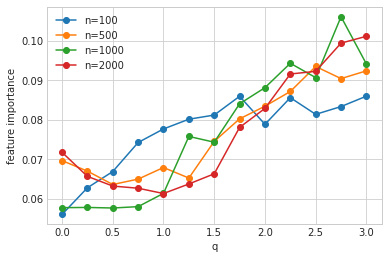

In [75]:
fig, ax = plt.subplots()

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models[n]["clf"].feature_importances_, '-o', color=f"C{i}", label=f"n={n}")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend()

In [76]:
SCENARIO1_TESTDATA = load_data("../data/scenario-1-testset-new.npz")

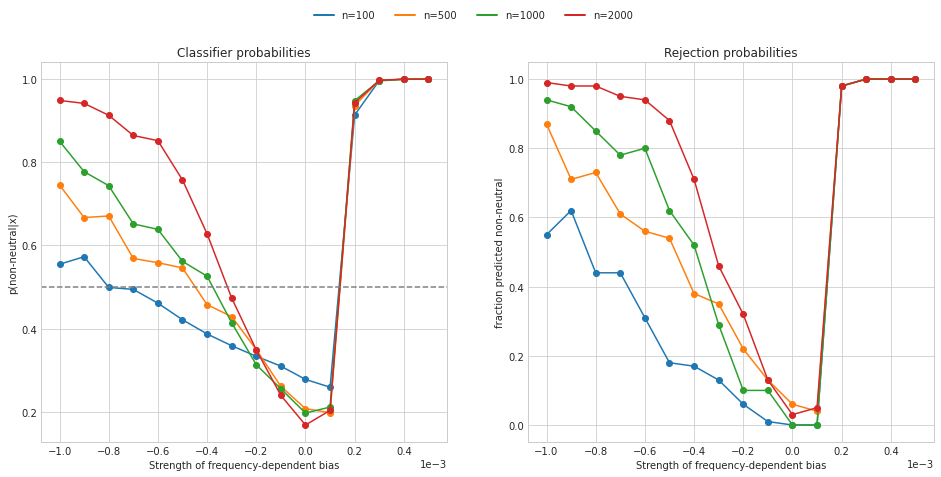

In [77]:
from matplotlib.lines import Line2D
import pandas as pd

fig, axes = plt.subplots(ncols=2, figsize=(16, 7))

for i, n in enumerate((100, 500, 1000, 2000)):
    testdata = SCENARIO1_TESTDATA[n]

    X_test, theta_test = testdata.dataset, testdata.theta
    y_test = (theta_test[:, 0].numpy() != 0).astype(int)
    
    probs = models[n]["clf"].predict_proba(X_test)[:, 1]
    pred = (probs > 0.5).astype(float)
    score = roc_auc_score(y_test, probs)
    
    df = pd.DataFrame(theta_test.numpy(), columns=["b", "p_mut", "p_death", "age_max", "_"])
    df["prob"] = probs
    df["pred"] = pred
    for l, label in enumerate(("prob", "pred")):
        d = df.groupby("b")[label].mean()
        values, labels= d.values, d.index
        axes[l].plot(labels, values, '-o', color=f"C{i}", label=f"n={n}")    
    
axes[0].set(
    ylabel="p(non-neutral|x)", 
    xlabel="Strength of frequency-dependent bias", 
    title="Classifier probabilities",
)

axes[1].set(
    ylabel="fraction predicted non-neutral",
    xlabel="Strength of frequency-dependent bias",
    title="Rejection probabilities",
)

axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['n=100', 'n=500', 'n=1000', 'n=2000'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.0), frameon=False)

axes[0].axhline(0.5, ls="--", color="grey")

plt.savefig(f"../plots/scenario1.png", 
            dpi=300, bbox_inches='tight')

## Scenario 2

age-structured model with b=0

* training data: (samples of) age-structured model with copyThresholdHigh $\in [2,\ldots,\text{All}]$ and pDeath $\in [0.02, 0.1]$
* observed data: samples (n=50,100,500,1000,2000) from age-structured model with specific $\text{copyThresholdHigh}_i$ values and $\text{pDeath}_i$ values
*outcome: 1-P(neutral)

As before plot the $\text{copyThresholdHigh}_i$  values on the x-axis and the 1-P(neutral) on the y-axis compare this to the rejection probability obtained from the Ewens-Watterson test (or even 3d plot with copyThresholdHigh_i values and $\text{pDeath}_i$ values on x and y axis)

In [78]:
SCENARIO2_TRAINDATA = load_data("../data/scenario-2-trainset-new.npz")

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier

models_2 = {}

for n in (100, 500, 1000, 2000):
    data = SCENARIO2_TRAINDATA[n]
    X, theta = data.dataset.numpy(), data.theta.numpy()
        
    X_train, X_dev, theta_train, theta_dev = train_test_split(
        X, theta, test_size=0.1, shuffle=True)
    y_train = (theta_train[:, 0] != 0).astype(int)
    y_dev = (theta_dev[:, 0] != 0).astype(int)
        
    clf = ExtraTreesClassifier(n_jobs=10, **PARAMS[f"2-{n}"])

    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_dev)[:, 1]
    score = roc_auc_score(y_dev, probs)
    
    models_2[n] = {
        "clf": clf,
        "dev score": score,
    }

In [80]:
models_2

{100: {'clf': ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_depth=90,
                       max_features='sqrt', min_samples_leaf=8,
                       min_samples_split=6, n_estimators=700, n_jobs=10),
  'dev score': 0.8003592517322494},
 500: {'clf': ExtraTreesClassifier(bootstrap=True, max_depth=20, max_features='sqrt',
                       min_samples_split=18, n_estimators=1500, n_jobs=10),
  'dev score': 0.8447184098627551},
 1000: {'clf': ExtraTreesClassifier(bootstrap=True, max_depth=20, max_features='sqrt',
                       min_samples_split=18, n_estimators=1500, n_jobs=10),
  'dev score': 0.8525385624679979},
 2000: {'clf': ExtraTreesClassifier(bootstrap=True, max_depth=20, max_features='sqrt',
                       min_samples_split=18, n_estimators=1500, n_jobs=10),
  'dev score': 0.8690899054384871}}

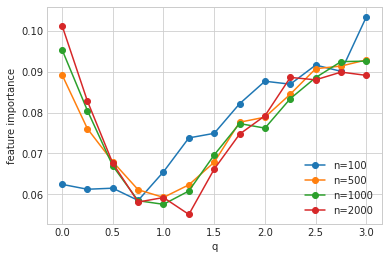

In [81]:
fig, ax = plt.subplots()

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models_2[n]["clf"].feature_importances_, '-o', color=f"C{i}", label=f"n={n}")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend()

In [82]:
SCENARIO2_TESTDATA = load_data("../data/scenario-2-testset-new.npz")

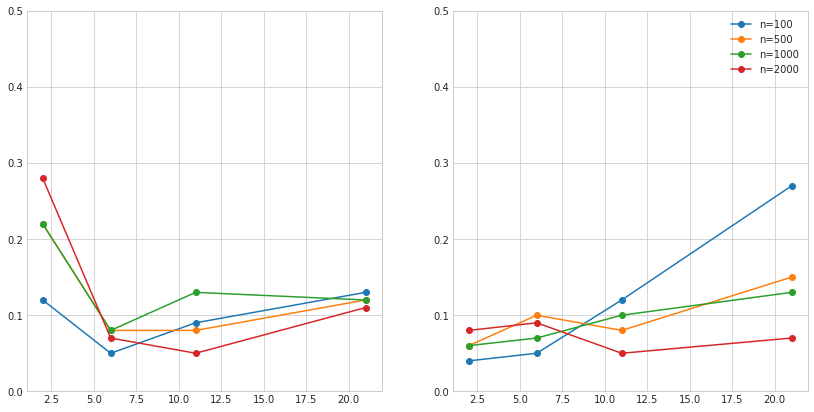

In [83]:
import pandas as pd

fig, axes = plt.subplots(ncols=2, figsize=(14, 7))

for j, n in enumerate((100, 500, 1000, 2000)):
    testdata = SCENARIO2_TESTDATA[n]

    for i, p_death in enumerate((0.02, 0.1)):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = (theta_test[:, 0] == 0.0) & (theta_test[:, 2] == p_death)
        
        X_test, y_test = X_test[index], y_test[index]
        
        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]
        pred = (probs > 0.5).astype(float)

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max", "_"])
        df["pred"] = pred
        d = df.groupby("age_max")["pred"].mean()
        values, labels = d.values, d.index
        axes[i].plot(labels, values, '-o', color=f"C{j}", label=f"n={n}")
        axes[i].set_ylim(0, 0.5)


plt.legend()

## Scenario 3

age-structured model with $b \approx 0$

* training data: (samples of) age-structured model with copyThresholdHigh $\in[2,…,All]$ and pDeath $\in [0.02,0.1]$ and $b \in[-0.001,0.0006]$
* observed data: samples (n=50,100,500,1000,2000) from age-structured model with specific copyThresholdHigh_i values and pDeath_i values and $b_i$ values
* outcome: 1-P(neutral)

In [84]:
betas = np.array(
    [-0.001, -0.0008, -0.0006, -0.0004, -0.0002, -0.0001, 
     0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005])

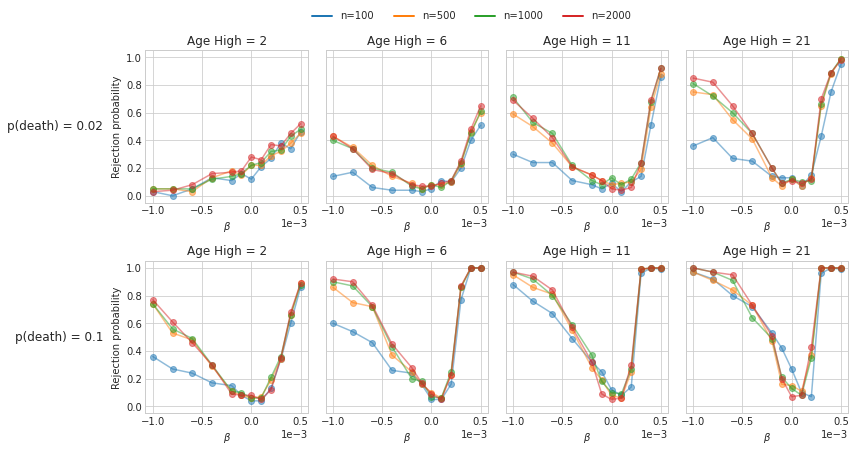

In [191]:
import pandas as pd
import sklearn.metrics as metrics


fig, axes = plt.subplots(ncols=4, nrows=2, sharey=True, figsize=(12, 6))

roc_curves = {}

for j, n in enumerate((100, 500, 1000, 2000)):
    testdata = SCENARIO2_TESTDATA[n]

    for i, p_death in enumerate((0.02, 0.1)):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = ((theta_test[:, 2] == p_death) & np.isin(theta_test[:, 0], betas))
        
        X_test, y_test = X_test[index], y_test[index]

        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]
        pred = (probs > 0.5).astype(float)

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max", "_"])
        df["pred"] = pred
        df["prob"] = probs
        for k, (age, g) in enumerate(df.groupby("age_max")):
            roc_curves[n, p_death, age] = metrics.roc_curve((
                g["b"] != 0).astype(int).values, g["prob"].values)
            g = g.groupby("b")["pred"].mean()
            axes[i, k].plot(g.index, g.values, '-o', color=f"C{j}", alpha=0.5)
            axes[i, k].set(xlabel="$\\beta$", title=f"Age High = {int(age)}")
            axes[i, k].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    
        axes[i, 0].set(ylabel="Rejection probability")

rows = [f'p(death) = {v}' for v in (0.02, 0.1)]
pad = 5
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['n=100', 'n=500', 'n=1000', 'n=2000'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.05), frameon=False)

plt.tight_layout()
plt.savefig("../plots/scenario3-rejection.png", dpi=300, bbox_inches='tight')

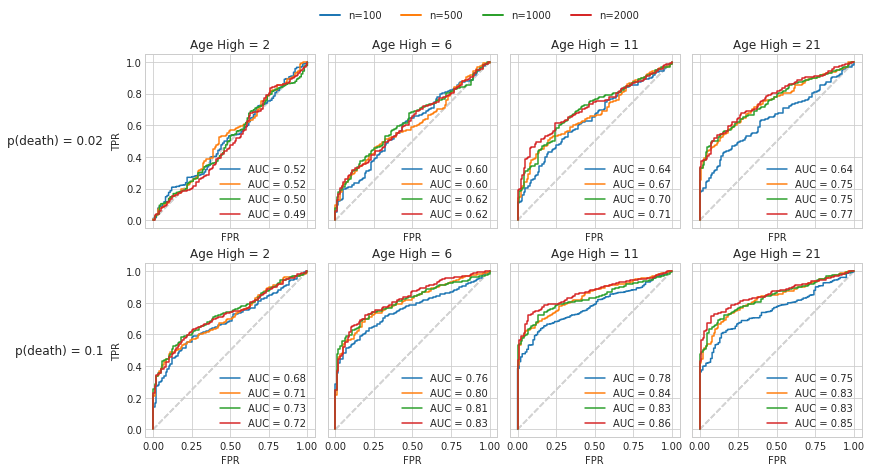

In [219]:
fig, axes = plt.subplots(
    nrows=2, ncols=4, sharey=True, sharex=True, figsize=(12, 6),
    constrained_layout=True
)
for j, n in enumerate((100, 500, 1000, 2000)):
    for i, p_death in enumerate((0.02, 0.1)):
        for k, age in enumerate((2, 6, 11, 21)):
            fpr, tpr, _ = roc_curves[n, p_death, age]
            roc_auc = metrics.auc(fpr, tpr)
            axes[i, k].plot(
                fpr, tpr, '-', color=f"C{j}", label=f"AUC = {roc_auc:.2f}")
            axes[i, k].set(xlabel="FPR", title=f"Age High = {int(age)}")
            axes[i, k].legend(loc="lower right")
            axes[i, k].plot([0, 1], [0, 1], color="lightgrey", linestyle="--", zorder=-1)
        axes[i, 0].set(ylabel="TPR")
        
rows = [f'p(death) = {v}' for v in (0.02, 0.1)]
pad = 5
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['n=100', 'n=500', 'n=1000', 'n=2000'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.08), frameon=False)
plt.savefig("roc_curves.png", dpi=300, bbox_inches='tight')